In [4]:
def plot_radiation_pattern(W, N, d_tx, wavelength):
    """Plots the array factor to check sidelobe levels."""
    theta = np.linspace(-np.pi, np.pi, 1000)
    AF = np.zeros_like(theta, dtype=complex)

    for t in range(len(theta)):
        response = array_response_vector(N, theta[t], d_tx, wavelength)
        AF[t] = np.abs(np.dot(W.T @ response, np.ones(W.shape[1])))

    AF_dB = 20 * np.log10(np.abs(AF) / np.max(np.abs(AF)))

    plt.figure(figsize=(8, 4))
    plt.plot(np.degrees(theta), AF_dB)
    plt.axvline(-45, color='r', linestyle='--', label="-45° Constraint")
    plt.axvline(45, color='r', linestyle='--', label="45° Constraint")
    plt.ylim(-50, 0)
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Array Factor (dB)")
    plt.title("Radiation Pattern of TX Beamforming")
    plt.legend()
    plt.grid()
    plt.show()


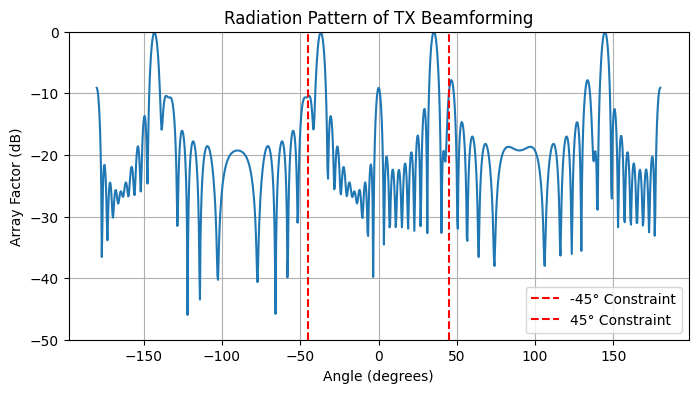

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def array_response_vector(N, theta, d, wavelength):
    """Computes the array response vector for a ULA."""
    k = 2 * np.pi / wavelength
    return np.exp(1j * k * d * np.arange(N) * np.sin(theta))

def generate_channel(N, M, scatterers, d_tx, d_rx, wavelength):
    """Generates the MIMO channel matrix with LoS and scattering components."""
    H = np.zeros((M, N), dtype=complex)
    theta_rx = np.linspace(-np.pi/4, np.pi/4, M)  # RX elements' angles
    theta_tx = np.linspace(-np.pi/4, np.pi/4, N)  # TX elements' angles
    
    # LoS component
    for m in range(M):
        H[m, :] = array_response_vector(N, theta_rx[m], d_tx, wavelength)
    
    # Scattering components
    for scatterer in scatterers:
        x, y = scatterer
        theta_s = np.arctan2(y, x)
        for m in range(M):
            H[m, :] += array_response_vector(N, theta_s, d_tx, wavelength)
    
    return H / np.sqrt(N)  # Normalize power

def zero_forcing_precoding(H):
    """Computes the Zero-Forcing precoding matrix."""
    W = np.linalg.pinv(H)  # Moore-Penrose pseudo-inverse
    return W / np.linalg.norm(W, axis=0)  # Normalize columns

# Parameters
N = 31  # TX elements
M = 3   # RX elements
d_tx = 0.5  # TX inter-element spacing (λ/2)
d_rx = 2.0  # RX inter-element spacing (2λ)
wavelength = 1.0  # Normalized wavelength
scatterers = [(40, -30), (70, 50)]  # Scatterer coordinates in λ

# Generate channel matrix
H = generate_channel(N, M, scatterers, d_tx, d_rx, wavelength)

# Compute ZF beamforming
W = zero_forcing_precoding(H)

def plot_radiation_pattern(W, N, d_tx, wavelength):
    """Plots the array factor to check sidelobe levels."""
    theta = np.linspace(-np.pi, np.pi, 1000)
    AF = np.zeros_like(theta, dtype=complex)

    for t in range(len(theta)):
        response = array_response_vector(N, theta[t], d_tx, wavelength)
        AF[t] = np.abs(np.dot(W.T @ response, np.ones(W.shape[1])))

    AF_dB = 20 * np.log10(np.abs(AF) / np.max(np.abs(AF)))

    plt.figure(figsize=(8, 4))
    plt.plot(np.degrees(theta), AF_dB)
    plt.axvline(-45, color='r', linestyle='--', label="-45° Constraint")
    plt.axvline(45, color='r', linestyle='--', label="45° Constraint")
    plt.ylim(-50, 0)
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Array Factor (dB)")
    plt.title("Radiation Pattern of TX Beamforming")
    plt.legend()
    plt.grid()
    plt.show()


plot_radiation_pattern(W, N, d_tx, wavelength)


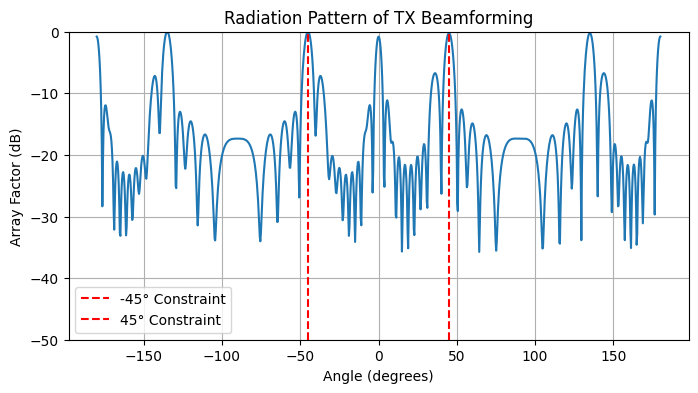

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def array_response_vector(N, theta, d, wavelength):
    """Computes the array response vector for a ULA."""
    k = 2 * np.pi / wavelength
    return np.exp(1j * k * d * np.arange(N) * np.sin(theta))

def generate_channel(N, M, scatterers, d_tx, d_rx, wavelength):
    """Generates the MIMO channel matrix with LoS and scattering components."""
    H = np.zeros((M, N), dtype=complex)
    theta_rx = np.linspace(-np.pi/4, np.pi/4, M)  # RX elements' angles
    
    # LoS component
    for m in range(M):
        H[m, :] = array_response_vector(N, theta_rx[m], d_tx, wavelength)
    
    # Scattering components
    for scatterer in scatterers:
        x, y = scatterer
        theta_s = np.arctan2(y, x)
        for m in range(M):
            H[m, :] += array_response_vector(N, theta_s, d_tx, wavelength)
    
    return H / np.sqrt(N)  # Normalize power

def zero_forcing_precoding(H, reg_factor=0.01):
    """Computes the Regularized Zero-Forcing precoding matrix to control sidelobes."""
    N, M = H.shape[1], H.shape[0]
    I = np.eye(M)  # Identity matrix for regularization
    W = np.linalg.inv(H.conj().T @ H + reg_factor * I) @ H.conj().T  # Regularized ZF
    W = W / np.linalg.norm(W, axis=1, keepdims=True)  # Normalize rows for power control
    return W
def apply_chebyshev_window(W, N, sidelobe_level=-40):
    """Applies a Dolph-Chebyshev window to reduce sidelobes."""
    from scipy.signal import chebwin
    window = chebwin(N, at=-sidelobe_level)  # Generate Chebyshev window
    return W * window[:, np.newaxis]  # Apply window to each column of W


def plot_radiation_pattern(W, N, d_tx, wavelength):
    """Plots the array factor to check sidelobe levels."""
    theta = np.linspace(-np.pi, np.pi, 1000)
    AF = np.zeros_like(theta, dtype=complex)
    
    for t in range(len(theta)):
        response = array_response_vector(N, theta[t], d_tx, wavelength)  # Shape (N,)
        beamformed_response = np.dot(W.T, response)  # Shape (M,)
        AF[t] = np.linalg.norm(beamformed_response)  # Aggregate power across M streams
    
    AF_dB = 20 * np.log10(np.abs(AF) / np.max(np.abs(AF)))
    
    plt.figure(figsize=(8, 4))
    plt.plot(np.degrees(theta), AF_dB)
    plt.axvline(-45, color='r', linestyle='--', label="-45° Constraint")
    plt.axvline(45, color='r', linestyle='--', label="45° Constraint")
    plt.ylim(-50, 0)
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Array Factor (dB)")
    plt.title("Radiation Pattern of TX Beamforming")
    plt.legend()
    plt.grid()
    plt.show()

# Parameters
N = 31  # TX elements
M = 3   # RX elements
d_tx = 0.5  # TX inter-element spacing (λ/2)
d_rx = 2.0  # RX inter-element spacing (2λ)
wavelength = 1.0  # Normalized wavelength
scatterers = [(40, -30), (70, 50)]  # Scatterer coordinates in λ

# Generate channel matrix
H = generate_channel(N, M, scatterers, d_tx, d_rx, wavelength)

# Compute ZF beamforming
W = zero_forcing_precoding(H, reg_factor=0.01)  # Regularization
W = apply_chebyshev_window(W, N, sidelobe_level=-40)  # Suppress sidelobes


# Plot the radiation pattern
plot_radiation_pattern(W, N, d_tx, wavelength)